<a href="https://colab.research.google.com/github/ayushs0911/Projects/blob/main/Food_Vision_Image_Classificaton_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement 
Constructing a Deep Learning Classification model to predict the class of 101 food items. 

## Signficance of analysis 
- For **Nutritional and Dietary** assessment. 
- This model can identify the Food items and in turn will help in making in more informed Consumption choices. 
- The World Obesity Atlas 2022, published by the World Obesity Federation, predicts that one billion people globally, including 1 in 5 women and 1 in 7 men, will be living with obesity by 2030 ([Source](https://www.worldobesity.org/news/one-billion-people-globally-estimated-to-be-living-with-obesity-by-2030#:~:text=The%20World%20Obesity%20Atlas%202022,living%20with%20obesity%20by%202030.)). 
- That's why, Accurately documenting dietary caloric intake is crucial to manage weight loss, but also presents challenges because most of the current methods for dietary assessment must rely on memory to recall foods eaten.

This project include tasks like :
- Downloading Tensorflow Dataset 
- Exploring dataset 
- Creating preprocessing function for our data
- Creating modeling callbacks
- Setting up mixed precision training 
- Building a Feature Extraction Model
- Fine-tuning the feature extraction model 
- Predicting the Model on custom images. 

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1576beaa-8a2e-5ac9-2ce9-0814e7ab9212)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


## Helper Functions 
I've made a series of helper functions which can be beneficial in various tasks. So instead of rewriting them again and again, I'll import [helper_functions.py](https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py) file from github. 


In [ ]:
import os 
if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
else:
  print("[INFO] 'helper_functions.py' already exists.skipping download.")

--2023-03-13 04:24:14--  https://raw.githubusercontent.com/ayushs0911/Projects/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-13 04:24:14 (83.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using TensorFlow Dataset to download Data 


In [ ]:
#get Tensorflow Datasets 
import tensorflow_datasets as tfds

To find all available datasets, usiing `list_builders()` method. <br>
After doing so, we can check to see if the one we're after (`"foor101"`) is present. 

In [ ]:
#list available datasets 
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
#loading data 
(train_data, test_data), ds_info = tfds.load(name = 'food101', #target dataset to get from TFDS
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised = True, #download data in tuple format(sample, label), e.g., (image, label)
                                             with_info = True) #include metadata

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete1DFGIX/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete1DFGIX/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
#Features of Food101 TFDS 
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
#Get class names 
class_names = ds_info.features['label'].names
class_names[:5], class_names[-5:] #class names of first five and last five in the last

(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'],
 ['tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'])

## Exploring the Food101 data 
Finding out few details about our dataset
- the shape of input data(image tensors)
- the datatype of our input data
- labels of our input data 
- do labels matchup with class names?

In [ ]:
#take one sample off the training data 
train_one = train_data.take(1)

As we used `as_supervised = True` parameter in `tfds.load()` method, data samples come in tuple format structure (data, label) or in our case (image_tensor, label)

In [ ]:
train_one

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_one:
  print(f"""
  Image Shape :{image.shape}
  Imagedtype : {image.dtype}
  Target Class from Food101 (tesnor form) : {label}
  Class Name(str form) : {class_names[label.numpy()]}
  """)


  Image Shape :(512, 288, 3)
  Imagedtype : <dtype: 'uint8'>
  Target Class from Food101 (tesnor form) : 93
  Class Name(str form) : steak
  


In [ ]:
#what does an image tensor looks like?
image

<tf.Tensor: shape=(512, 288, 3), dtype=uint8, numpy=
array([[[148, 103,  36],
        [147, 102,  35],
        [147, 102,  35],
        ...,
        [146, 111,  53],
        [146, 111,  53],
        [146, 111,  53]],

       [[147, 102,  35],
        [147, 102,  35],
        [148, 103,  36],
        ...,
        [145, 110,  52],
        [145, 110,  52],
        [145, 110,  52]],

       [[143,  98,  31],
        [144,  99,  32],
        [146, 101,  33],
        ...,
        [146, 111,  55],
        [146, 111,  55],
        [145, 110,  54]],

       ...,

       [[113,  69,  94],
        [113,  69,  94],
        [112,  68,  93],
        ...,
        [ 77,  53,  67],
        [ 76,  52,  66],
        [ 78,  54,  68]],

       [[115,  71,  96],
        [115,  71,  96],
        [114,  70,  95],
        ...,
        [ 79,  55,  69],
        [ 81,  54,  69],
        [ 82,  55,  70]],

       [[116,  72,  97],
        [117,  73,  98],
        [117,  73,  98],
        ...,
        [ 75,  51,  6

In [ ]:
# min and max values 
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

It looks like image tensors have values between 0 & 225 (standard red, green, blue color values) amd values are of datatype `unit8`.

## Plot an image from TensorFlow Datasets

(-0.5, 287.5, 511.5, -0.5)

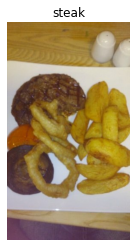

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.title(class_names[label.numpy()]) 
plt.axis(False)

## Creating preprocessing functions for our data


In [ ]:
def preprocess_img(image, label, img_shape = 224):
  """
  Convert image datatype from 'unit8' to 'float32' and reshape image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
#trying our function on a target image 
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...{image.shape}, \nDatatype:{image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...\nShape:{preprocessed_img.shape}, \n datatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[148 103  36]
  [147 102  35]
  [147 102  35]
  ...
  [146 111  53]
  [146 111  53]
  [146 111  53]]

 [[147 102  35]
  [147 102  35]
  [148 103  36]
  ...
  [145 110  52]
  [145 110  52]
  [145 110  52]]]...(512, 288, 3), 
Datatype:<dtype: 'uint8'>

Image after preprocessing:
 [[[147.30612  102.30612   35.30612 ]
  [147.27551  102.27551   35.27551 ]
  [148.61224  103.61224   36.612244]
  ...
  [145.61224  110.61225   52.612247]
  [145.35715  110.35714   52.357143]
  [145.35715  110.35714   52.357143]]

 [[142.34694   97.34694   30.34694 ]
  [144.85715   99.85714   32.42857 ]
  [146.       101.        33.      ]
  ...
  [144.14285  109.14285   53.142857]
  [144.14285  109.14285   53.142857]
  [143.2857   108.285706  52.28571 ]]]...
Shape:(224, 224, 3), 
 datatype: <dtype: 'float32'>


The input data converted from `uint8` yo `float32` and gets reshaped from its current shape to `(224,224,3)`

(-0.5, 223.5, 223.5, -0.5)

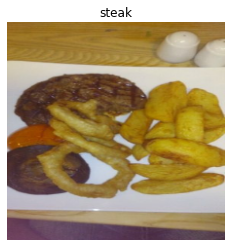

In [ ]:
# we can still plot our preprocessed image
plt.imshow(preprocessed_img/255.)#rescaling the image
plt.title(class_names[label])
plt.axis(False)

## Batch and Prepare dataset 
- Turning data into batches, because computing on batches is memory efficient. 
- We will turn 101,000 image tensors and lables into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU. 
- For this leveraging methods from `tf.data API` 

**Things to note:**
- Can't batch tensors of different shapes (eg. different image sizes, need to reshape first, Hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it imahes shuffled, ideally this number would be all of the samples in your training set, however if your training set is large, this buffer might not fit in memory. 
- for methods with the `num_parallel_calls` parameter available(such as `map()`), setting it to `num_parallel_calls = tf.data.AUTOTUBE` will parallelize preprocessing and significantly improve speed. 


In [ ]:
#Map preprocessing function to training data(and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size =1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

#Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
#turning test data into batches
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Modelling callbacks
- `tf.keras.callbacls.TensorBoard()` : allows us to keep track of our model's training history so we can inspect it later 
- `tf.keras.callbacks.ModelCheckpoint` : saves our model's progress at various intervals so we can load it and resume layer without having to retain it. 


In [ ]:
from helper_functions import create_tensorboard_callback

#create modelcheckpoint callback to save model's progress
checkpoint_path = 'model_checkpoint/cp.ckpt' #saving weigths requires '.ckpt' extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor ='val_accuracy',#saving model weights with best validation accuracy
                                                      save_best_only = True,# only save the best weights 
                                                      save_weights_only = True,#only save model weights (not whole model)
                                                      verbose =0)

## Setup Mixed precision training 
In computer science, float32 is known as *single-precision floating-point format.* The 32 means it usually occupies 32 bits in memory. <br>
GPU has a limited memory, therefore it can only handel a number of float 32 tensors at the sametime. This is where we use mixed precision training.  <br>
**Mixed Precision training** involves using a mix of float16 and float32 tensors to make better use of GPU's memory. It will use less memory wherever possible and in turn run faster. 


In [ ]:
#Turn on mixed precision training 
from tensorflow.keras import mixed_precision 
mixed_precision.set_global_policy(policy = 'mixed_float16') #set global policy to mixed precision 

Now we can check the global dtype policy using `mixed_precision.global_policy()` method

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

Since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training. 

## Training Feature Extraction Model
**To build the model**
- Using `EfficientNetB0` for `tf.keras.applications` pre-trained on ImageNet as our base model 
  - we'll download this without the top layers using `include_top = False` parameter so we can create our own output layers 
- Freeze base model so we can use pre-learned patterns the base model found on ImageNet. 
- Putting together input, base model, pooling and output layers in **Functional Model.**



In [ ]:
from tensorflow.keras import layers 

#create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False #freezing model layers 

#create functional model 
inputs = layers.Input(shape = input_shape, name = 'input_layer')
#EfficientNetBX models have rescaling built-in, so no need to use
# if model doesn't have built in preprocessing then use :
# x = layers.Rescaling(1/255.)(x)
x = base_model(inputs, training = False) #set base_model to inference mode only 
x = layers.GlobalAveragePooling2D(name = 'pooling_layer')(x)
x = layers.Dense(len(class_names))(x)

#separate activation of output layer so we can output float32 activation =s
outputs = layers.Activation('softmax', dtype = tf.float32, name ='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)



16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#compiling the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
#check the dtype_policy attributes of layers in our model 
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
#checking the layers in base model and their dtype policy 
for layer in model.layers[1].layers[:10]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">


## Fit the feature extraction model
- Training for 3 epochs, that will be enough for out top layers to adjust their weights enough to our food image data. 
- To save time, we'll only validate on 15% of test data.  


In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs =3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     callbacks = [create_tensorboard_callback('training_logs',
                                                                                              'efficientnetb0_classes_all_data_feature_extract'),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_classes_all_data_feature_extract/20230313-043751
Epoch 1/3
2368/2368 [==============================] - 213s 82ms/step - loss: 1.7218 - accuracy: 0.5807 - val_loss: 1.1321 - val_accuracy: 0.6978
Epoch 2/3
2368/2368 [==============================] - 191s 80ms/step - loss: 1.2010 - accuracy: 0.6880 - val_loss: 1.0328 - val_accuracy: 0.7211
Epoch 3/3
2368/2368 [==============================] - 229s 96ms/step - loss: 1.0530 - accuracy: 0.7256 - val_loss: 0.9945 - val_accuracy: 0.7283


### Evaluating the model on whole test dataset 

In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model 

790/790 [==============================] - 66s 83ms/step - loss: 0.9977 - accuracy: 0.7291


[0.997734010219574, 0.7290692925453186]

###  Load and evaluate our model's checkpoints by 
1. Calling the `load_weights` method on model & passing it the path to where our checkpointed weights are stored. 
2. Calling `evaluate()` on the model with loaded weights. 

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model_with_loaded_weights = model.evaluate(test_data)

790/790 [==============================] - 52s 66ms/step - loss: 0.9977 - accuracy: 0.7291


## Preparing our model's layers for fine-tuning 
Our feature extraction model is showing some great promise after 3 epochs. But since we've got so much data, it's probably worthiwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data)



We created our Feature-Extraction model with all layers in base model 'Frozen', by setting `base_model.trainable = False`. Let's make our layers trainable. 

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Right now, base model layers are untrainable. 

In [ ]:
for layer in model.layers:
  layer.trainable = True #setting all layers to trainable 
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Alright, it seems like each layer in our loaded model is trainable. But what if we got a little deeper and inspected each layer in base model. 

In [ ]:
#checking the layers in base model and see their characteristics 
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
rescaling_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float

It looks like each layer in our base model is trainable and every layer is using dtype policy : `mixed_policy16`

### Introducing more callbacks 
- The `EarlyStopping` callback monitors a specified model performance metrics (e.g. `val_loss`) and when it stops improving for a specified number of epochs, it automatically stops training. 
- Using `EarlyStopping` callback combined with `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving. 
**Lets' set both of these upto monitor our model's `val_loss`*

In [ ]:
#Earylstopping to stop training if model's val_loss doesn't improve for 3 epochs 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 3)

# creating model checkpoint callback to save best model during fine-tuning 
checkpoint_path = 'fine_tune_checkpoints/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = 'val_loss')

We will also use `ReduceLROnPlateau` callback, it monitors a specified metric and when that metric stops improving, it reduces the **learning rate** by a specified factor(e.g. divides the learning rate by 10).

- As training goes on and our model gets closer to it's ideal performance(also called **convergence**), we want the amount it learns to be less and less. <br>
- For this we'll create an instance of `ReduceLROnPlateau` callback to monitor the validation loss just like `EarlyStopping` callback. <br>
- Once the validation loss stops improving for 2 or more epochs, we'll reduce the learning rate by a factor of 5. 
<br>
- To make sure learning rate doesn't get too low (and potentially results in our model learning nothing), we'll set the minimum learning rate to `1e-7`. 

In [ ]:
# creating learning rate reduction callback 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2, #multiply learning rate by 0.2 (reduce by 5x)
                                                 patience =2,
                                                 verbose = 1,#print out when learning rate goes down
                                                 min_lr = 1e-7)

Now before we start tuning, we've got to recompile our model.<br>

We'll use sparse categorical crossentropy as loss and since we're fine-tuning, we'll use **10x lower learning rate** than the Adam optimizers default (`1e-4` instead of `1e-3`)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
#start to fine-tune all layers 
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs =100,
                                                        steps_per_epoch = len(train_data),#validation during training on 15% of test data
                                                        validation_data = test_data,
                                                        validation_steps = int(0.15*len(test_data)),
                                                        callbacks = [create_tensorboard_callback('training_logs', 'efficientb0_101_classes_all_data_fine_tuning'), #training the model training logs
                                                                     model_checkpoint,# save only the best model during training
                                                                     early_stopping, #stop model after X epochs of no imporvements
                                                                     reduce_lr]) #reducing the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230313-061613
Epoch 1/100
2368/2368 [==============================] - 360s 151ms/step - loss: 0.5284 - accuracy: 0.8533 - val_loss: 0.7554 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 356s 149ms/step - loss: 0.2952 - accuracy: 0.9150 - val_loss: 0.8349 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9541
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 358s 150ms/step - loss: 0.1577 - accuracy: 0.9541 - val_loss: 0.9640 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 360s 151ms/step - loss: 0.0313 - accuracy: 0.9930 - val_loss: 1.0311 - val_accuracy: 0.8027 - lr: 2.0000e-05


Note : If we don't use mixed precision or techniques like `prefetch()` in the Batch and Prepare datasets section, your model fine-tuning probably takes upto 2.5-3x longer per epoch. 

Index of Highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probability value, the less the model thinks that the target image is specific class. 

## Visualising predictions on test images 
Our model can't just predict on any image of our choice. First it has to be loaded into tensors. <br>
We'll create a functions to load an image into a tensor. <br>

It'll 
- read in a target image filepath `tf.io.read_file()`
- Turn the image into Tensor using `tf.decode_image()`
- resize the image to the same as images our model has been trained (224x224) using `tf.image.resize()`
- Scale the image. 



In [ ]:
def load_and_prep_image(filename, img_shape = 224, scale = True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255. 
  else:
    return img 


Downloading Some custom images from google storage 

In [ ]:
from helper_functions import unzip_data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data('custom_food_images.zip')

--2023-03-13 07:27:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  81.3MB/s    in 0.2s    

2023-03-13 07:27:32 (81.3 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



We can load these in and turn them into tensors using our `load_and_prep_image()` function but first we need a list of image filepaths 

In [ ]:
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]

In [ ]:
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 27ms/step


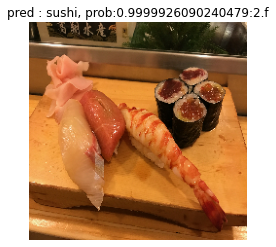

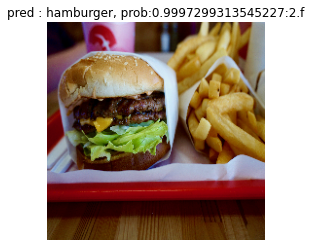

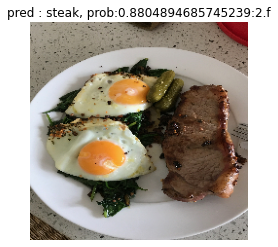

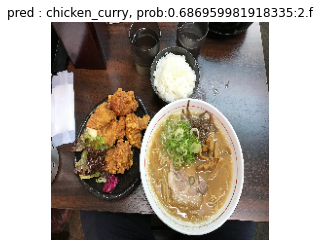

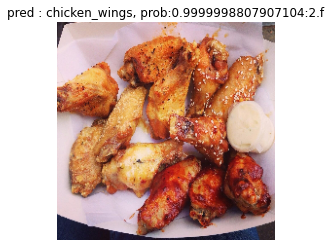

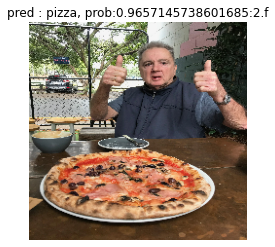

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis =0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred : {pred_class}, prob:{pred_prob.max()}:2.f")
  plt.axis(False)

## Our Food Vision model has come to life!